<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 10 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 18 March 2023, with material by by John K. Kruschke</div>

# Bayesian Hierarchies Lab
Just like **objects** derive from other **objects** in OO programming, ***specialized*** models derive from more ***abstract*** models in Data Science. In this way, we can produce hierarchies that yield more abstract models from more specialized datasets, so we can get more general, less-derived models from more specialized datasets! 

<br />
<center>
<img src="ipynb.images/red-sox-hurler.jpg" width=900 />
</center>

Boston is the home of one of the oldest baseball teams: The Red Sox. You all need to catch at least one baseball game at historic Fenway park!

We've modelled drivers and teams in F1, but how do we model ***groups*** of teams or ***groups*** of players?

For example, all greek soccer teams versus all English soccer teams? I bet the english soccer teams come on top.

We model that with Bayesian **hierarchies**.

The hierarchical structure of a model is an expression of how you think the data should be meaningfully modeled and the model description captures *group* aspects of the data that you care about. Using Bayesian estimation, you supply a prior distribution on group parameters, and infer an entire posterior distributions across the joint parameter space.

In the National league (not the American league that the Red Sox belong to), pitchers get to bat as well. But pitchers are trained to *throw* a ball, not to *bat* it. 

Is that the same in cricket? 

I bet that pitchers have much worse batting averages than batters, but how to build a model to prove that?

In this notebook, we are going to introduce two new concepts:

- Parameters of simulated pdfs, when unknown, can be made to be simulated pdfs themselves. This gives us more flexibility in asking our computer to sample a wider expanse of state space for posteriors.

- Parameter pdfs can be indexed to belong to an array of *latent* or *apparent* categories, a.k.a. **hierarchies**, so that we can give the computer the flexibility to detangle complex data and come up with a solution to our modeling  puzzle. If Bob likes to eat a lot of ice-cream, and Alice likes to eat a lot of french fries, when we include a lot of Alice and Bob eating data, the computer will be confused whether to model individuals as ice-cream loving or french-fies-loving (it woll probably model them as *both*). But if we index our data appropriately when we specify the data likelihood pdf, the computer will put individuals in the right category, or *hierarchy*.

# Analogy with OO
In OO, you can specialize classes to give them distinguishing characteristics:

In [1]:
class mlb:
      def play(self):
          print('baseball player playing')

class pitcher(mlb):
      def play(self):
          print('pitcher pitching')
        
class batter(mlb):
      def play(self):
          print('batter hitting')

f = mlb()
f.play()

p = pitcher()
p.play()

b = batter()
b.play()

baseball player playing
pitcher pitching
batter hitting


We can do the same thing with models in data science: We can build a generic model for all players, and we can derive specialized models for players belonging to different groups, like attackers and defenders in soccer, and pitchers and batters  in baseball.

# Note
`pymc3.stats.hpd` is deprecated in the pymc3 library. To replace the code, use `arviz.hdi`. See [here](https://python.arviz.org/en/stable/api/generated/arviz.hdi.html).

## Batting averages in Baseball
During a year of games, different players have different numbers of opportunities at bat, and on some of these opportunities a player might actually hit the ball.

That ratio, of hits divided by opportunities at bat, is called the [batting average](https://en.wikipedia.org/wiki/Batting_average_(baseball)) of each player.

Assume we have data consisting of records from 948 players in the 2012 regular season of Major League Baseball.

To give some sense of the data, there were 324 pitchers with a median of 4.0 at bats, 103 catchers with a median of 170.0 at - bats, and 60 right fielders with a median of 340.5 at bats, along with 461 players in six other positions.

For every pair of players, we could ask how much their estimated batting abilities differ. 

For every pair of positions, we can also ask how much their batting abilities differ. For example, do outfielders have different batting averages than basemen?

We need to estimate the batting abilities for individual players, for positions, and for groups of players. Clearly, we expect the  batting ability of pitchers to be lower than that for catchers, for example.

Each category has its own modal bias $ω_c$, from which all subject biases in the category are assumed to be drawn.

When $κ$ is large, the category biases $ω_c$ are tightly concentrated.

A prior on $κ_c$ applies independently to each $κ_c$ in a manner fixed by the prior constants $\alpha_κ$ and $beta_κ$, and the $κ_c$’s do not mutually inform each other via that part of the hierarchy.

Each row could also contain a unique subject identifier.

Let's start by putting all 948 players under a single over-arching distribution (the pooled model), then the estimates for two players with identical batting records would be identical regardless of the position they play.

Players with many at bats should have somewhat less shrinkage of their individual estimates than players with few at-bats and who maybe had estimates dominated by position information.

In [2]:
import numpy as np
np.random.seed(0)

import arviz as az
import pandas as pd
import pymc as pm

import pytensor
from pytensor import tensor as tt

# use bool_ instead of bool
data = np.random.randint(0, 2, size=100).astype(np.bool_)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
df = pd.concat(
    map(pd.read_csv, ["C:\\Users\\shash\\OneDrive\\Desktop\\Northeastern\\SEM 2\\Data Science Engineering Methods and Tools\\Class Material and PPTs\\W10L1\\BattingAverage.csv"]), ignore_index=True)
df.head()

,Player,PriPos,Hits,AtBats,PlayerNumber,PriPosNumber
0,Fernando Abad,Pitcher,1,7,1,1
1,Bobby Abreu,Left Field,53,219,2,7
2,Tony Abreu,2nd Base,18,70,3,4
3,Dustin Ackley,2nd Base,137,607,4,4
4,Matt Adams,1st Base,21,86,5,3


In [4]:
num_players = len(df)
num_players

948

Let's explain the intuition behind the parametric form of the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) a bit more. Very important for baseball. 

<br />
<center>
<img src="ipynb.images/atbat.png" width=400 />
</center>

Whereas the Poisson distribution is a *count* statistic, the Beta distribution can be thought of as representing a distribution of *probabilities*- that is, it represents all the possible values of a probability when we don't know what that probability is. The domain of the Beta distribution is (0, 1), just like a probability, so we already know we're on the right track.

Imagine you want to predict a baseball player's season-long batting average.  We know it's somewhere around .300, like we know the average number of text phones I can expect my girlfriend to receive per day before I get worried too much.

The baseball player can get into a lucky streak and get an average of 1.000, or an unlucky streak with an average of 0, neither of which are a good predictor. Let's go in with prior expectations: In history, most season batting averages have hovered between something like .200 and .350.

Let's plot a Beta distribution with parameters α=81 and β=219. We know that the formula for the mean of the beta distribution is:

$$ \frac{\alpha}{\alpha + \beta} = \frac{81}{81+219} =.270$$

and the distribution lies almost entirely within the reasonable range for a batting average \[.2, .35\].

Plot histogram:
```
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

data = stats.beta.rvs(81, 219, loc = 0, scale = 1, size=1000)
plt.hist(data,bins='auto',normed=True)
```

(array([ 0.30762237,  0.61524473,  1.23048946,  2.61479011,  4.76814667,
         6.46006968,  7.53674796, 11.84346107, 12.15108344, 16.15017419,
        15.07349591, 17.99590838, 15.07349591, 10.76678279,  9.53629333,
         8.45961505,  5.07576903,  3.07622366,  1.99954538,  0.9228671 ,
         1.23048946,  0.46143355,  0.15381118,  0.        ,  0.15381118,
         0.15381118]),
 array([0.1977411 , 0.20424257, 0.21074405, 0.21724553, 0.22374701,
        0.23024849, 0.23674996, 0.24325144, 0.24975292, 0.2562544 ,
        0.26275588, 0.26925735, 0.27575883, 0.28226031, 0.28876179,
        0.29526326, 0.30176474, 0.30826622, 0.3147677 , 0.32126918,
        0.32777065, 0.33427213, 0.34077361, 0.34727509, 0.35377657,
        0.36027804, 0.36677952]),
 <BarContainer object of 26 artists>)

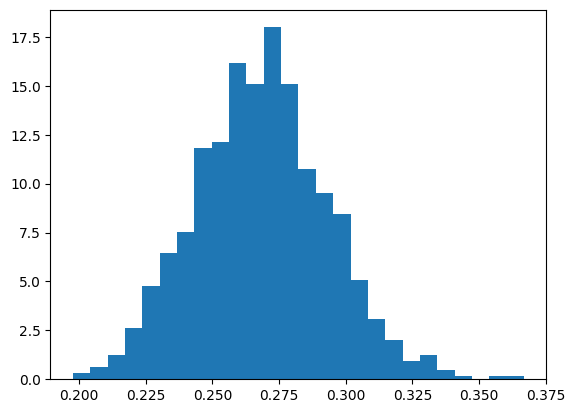

In [5]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

data = stats.beta.rvs(81, 219, loc=0, scale=1, size=1000)
plt.hist(data, bins='auto', density=True)


Imagine now the player gets his first at bat and has a single hit. His record for the season is now 1 hit; 1 at bat. 

We update our probabilities by shifting the entire curve over just a bit to reflect our new information. The new Beta distribution will be:

$$ \text{Beta}(\alpha_0 + \text{hits}, \beta_0 + \text{misses})$$
 
Where $α_0$ and $β_0$ are the parameters we started with: 81 and 219. Thus, in this case, $α$ has increased by 1 (his one hit), while $β$ has not increased at all (no misses yet). Read [here](https://en.wikipedia.org/wiki/Conjugate_prior#Example) for proof. It's about *conjugate priors*: The beta distribution is a conjugate prior for a binomial data likelihood. This means that if the data likelihood is a binomial and the prior is a beta, the posterior will also be a beta.

Suppose halfway through the season he has been up to bat 300 times, hitting 150 out of those times. Let's plot!
```
data = stats.beta.rvs(81 + 150, 219 + 150, loc = 0, scale = 1, size=1000)
plt.hist(data,bins='auto',normed=True)
```

(array([ 0.19559116,  0.58677348,  1.36913812,  1.36913812,  3.71623205,
         4.69418785,  9.58396686,  9.77955802, 13.10460775, 16.42965748,
        18.38556909, 19.55911605, 21.31943649, 18.97234257, 16.42965748,
        12.12665195,  9.77955802,  8.01923758,  3.71623205,  2.34709393,
         2.15150277,  0.78236464,  0.58677348,  0.58677348]),
 array([0.32358649, 0.3286992 , 0.33381191, 0.33892461, 0.34403732,
        0.34915002, 0.35426273, 0.35937543, 0.36448814, 0.36960084,
        0.37471355, 0.37982626, 0.38493896, 0.39005167, 0.39516437,
        0.40027708, 0.40538978, 0.41050249, 0.41561519, 0.4207279 ,
        0.4258406 , 0.43095331, 0.43606602, 0.44117872, 0.44629143]),
 <BarContainer object of 24 artists>)

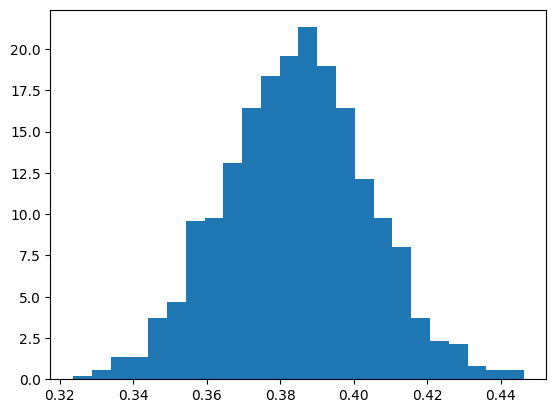

In [6]:
data = stats.beta.rvs(81 + 150, 219 + 150, loc=0, scale=1, size=1000)
plt.hist(data, bins='auto', density=True)


Notice the curve is now both *thinner* (0.44 - 0.34 = 0.10 versus 0.34 - 0.20 = 0.14) and *shifted* to the right (higher batting average) than it used to be: We have a better sense of what the player's batting average is!

The Beta distribution is best for representing a probabilistic distribution of probabilities- the case where we don't know what a probability is in advance, but we have reasonable guesses.

# Useful reparametrization of the Beta
We reparametrize $\alpha$ and $\beta$ into $\omega$ and $\kappa$:
```
omega = 2
kappa = 1
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1
alpha, beta
```

In [7]:
omega = 2
kappa = 1
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1
alpha, beta

(1, 2)

```
# prior parameters
omega = 0.5
kappa = 100
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()
```

In [8]:
# prior parameters
omega = 0.5
kappa = 100
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

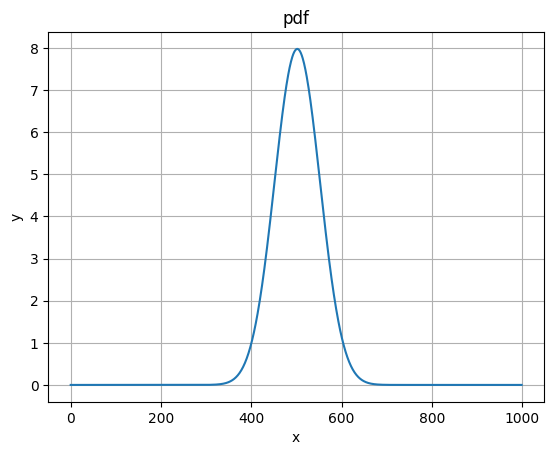

In [9]:
# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

We see that for high values of kappa, we have high certainty.

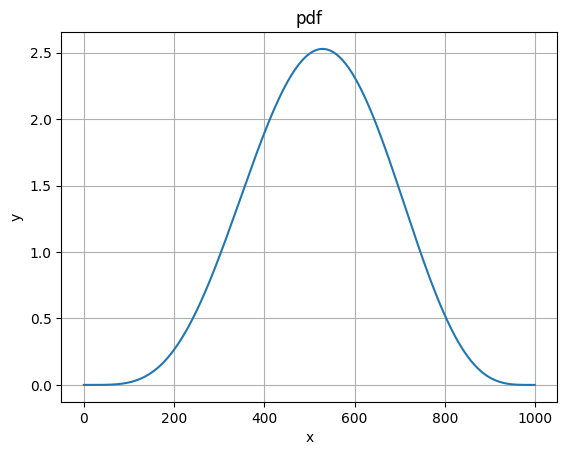

In [10]:
# prior parameters
omega = 0.5
kappa = 10
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

For lower values of kappa, not so sure anymore.

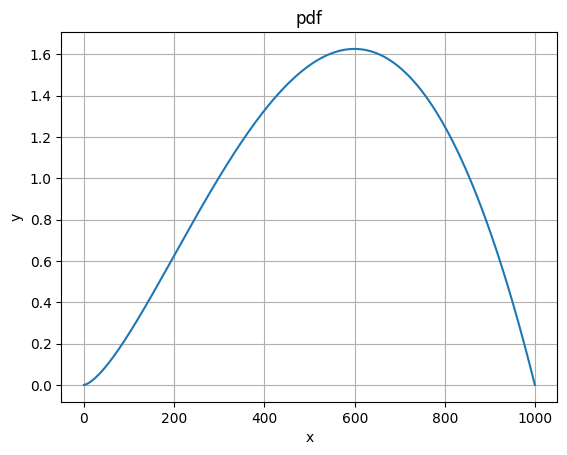

In [11]:
# prior parameters
omega = 0.5
kappa = 4
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

Then, for even lower values of kappa, strange things happen: We get a bias in one direction and we observe more and more one-sided results, eventually down to an absolute certainty!

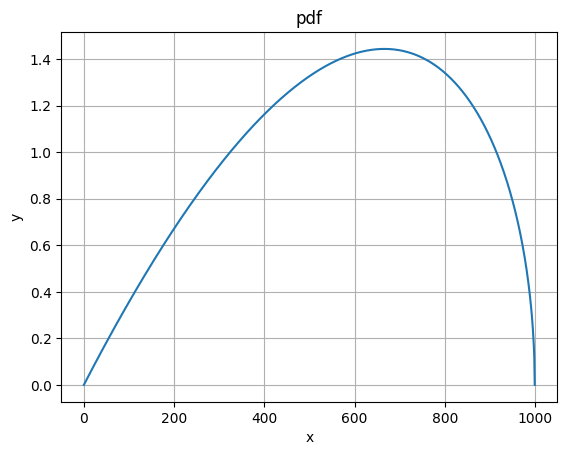

In [12]:
# prior parameters
omega = 0.5
kappa = 3
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

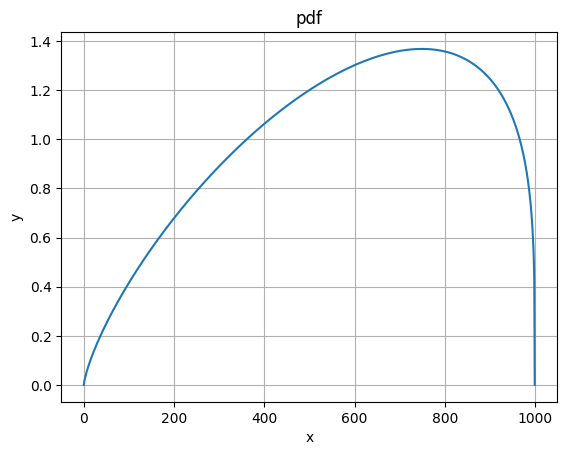

In [13]:
# prior parameters
omega = 0.5
kappa = 2.5
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

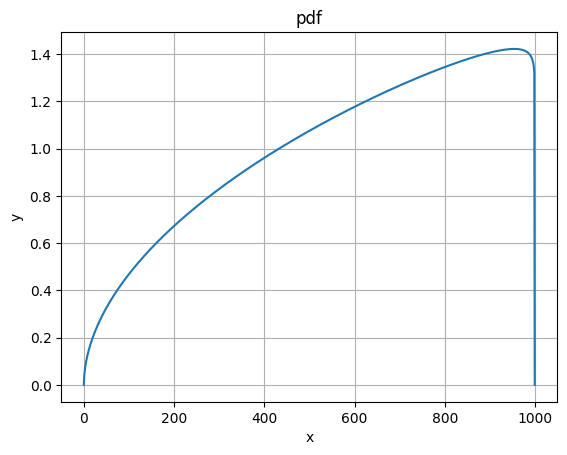

In [14]:
# prior parameters
omega = 0.5
kappa = 2.05
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

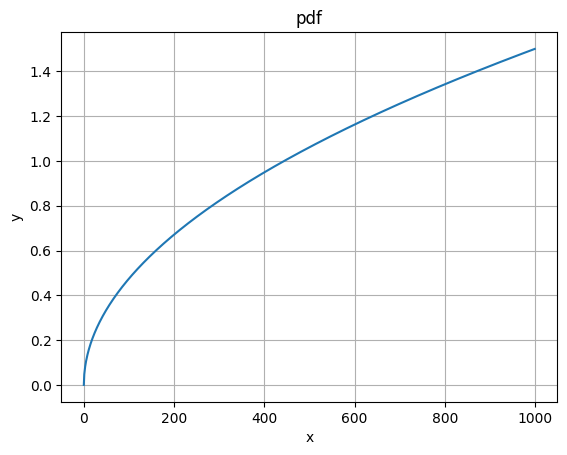

In [15]:
# prior parameters
omega = 0.5
kappa = 2
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

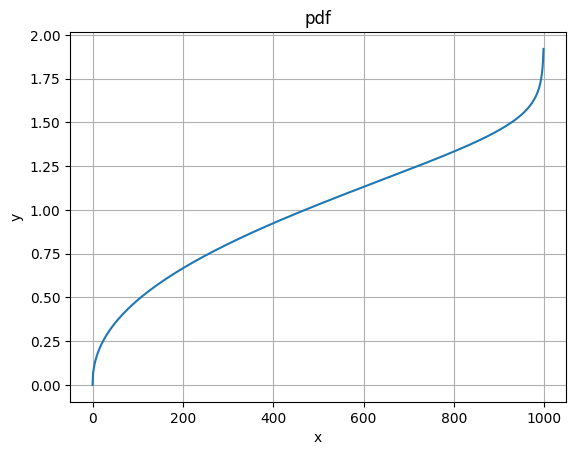

In [16]:
# prior parameters
omega = 0.5
kappa = 1.9
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

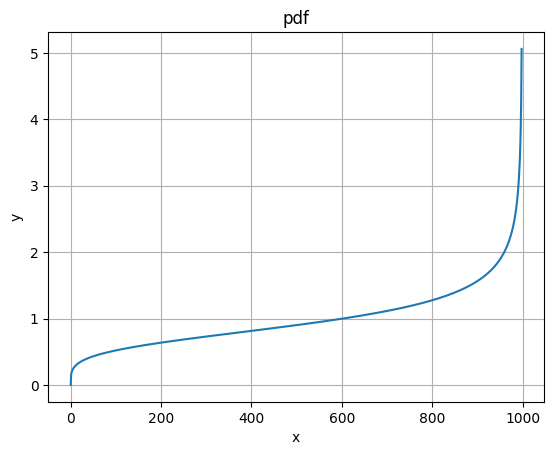

In [17]:
# prior parameters
omega = 0.5
kappa = 1.5
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

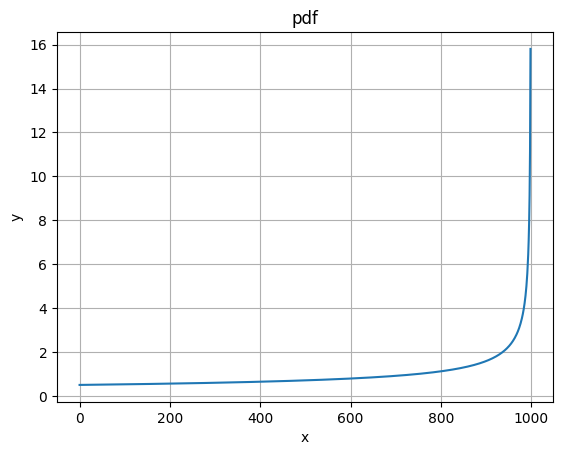

In [18]:
# prior parameters
omega = 0.5
kappa = 1
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

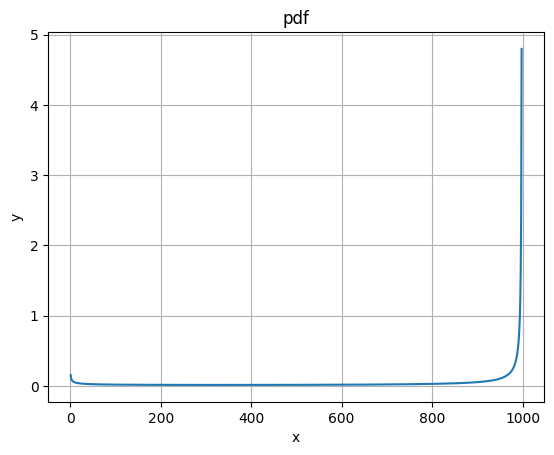

In [19]:
# prior parameters
omega = 0.5
kappa = 0.01
alpha, beta = omega*(kappa - 1) + 1, (1 - omega)*(kappa - 2) + 1

# calculate posterior distribution, using a beta distribution
variates = stats.beta(alpha, beta)

# beta distribution
xs = np.linspace(0, 1, num=1000)
pdf = variates.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

Interesting reparametrization!

# The Single hierarchy Model
A hierarchical model is a model where the data likelihood parameters are modeled with pdfs that have parameters *which themselves are modeled with other pdfs*! It's craaaaaaaazy! In the model below, our data likelihood is modeled with a binomial (after all, the number of hits in $n$ times at bat is the same thing as the number of wins in $n$ races), the parameter of the binomial (theta) is modeled with a pdf (a Beta), *but the parameters of the Beta are also modeled with other pdfs (another Beta and a Gamma)*. The name for this kind of model is a **hierarchical model**.

But the salient thing about the model we build below is that the theta parameter does not depend on *player position*.

We assume that each player has a different hitting average, but we shrink that to a league-average model.

In other words, *all players belong to the same model*.

Since we have a count of `Hits`` and a number of `AtBats`, the **binomial** is our optimal data likelihood pdf for our dataset.

We use the same omega/kappa decomposition we used above:
```
with pm.Model() as single_hierarchy_model:
    # hyperpriors
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=num_players)
    y = pm.Binomial('y', n=df['AtBats'], p=theta, observed=df['Hits'])
```

In [20]:
import pymc as pm

with pm.Model() as single_hierarchy_model:
    # hyperpriors
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-1)+1, beta=(1-omega)*(kappa-2)+1, shape=num_players)
    y = pm.Binomial('y', n=df['AtBats'], p=theta, observed=df['Hits'])

    

We run:
```
with single_hierarchy_model:
    single_hierarchy_trace = pm.sample(cores=1)
```

In [21]:
with single_hierarchy_model:
    single_hierarchy_trace = pm.sample(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.


Plotting [energy transition distribution and marginal energy distribution](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_energy.html) in Hamiltonian Monte Carlo algorithms may help diagnose poor exploration of state space. In brief, you want the two distribution (energy and energy transition) as close as possible. 

If you have the energy transition distribution (diff(Energy)) much more narrow than energy distribution, it means you dont have enough energy to explore the whole parameter space and your posterior estimation is likely biased.

If the two distributions are *not close*, you should improve your model by trying different reparameterizations, standardizing the scale of the predictors, or using more informative priors to avoid the part of parameter space that might be problematic.

This is if you run the NUTS simulator and [Hamiltonian Monte Carlo](https://arxiv.org/pdf/1701.02434.pdf).
```
az.plot_energy(single_hierarchy_trace)
```

<AxesSubplot: >

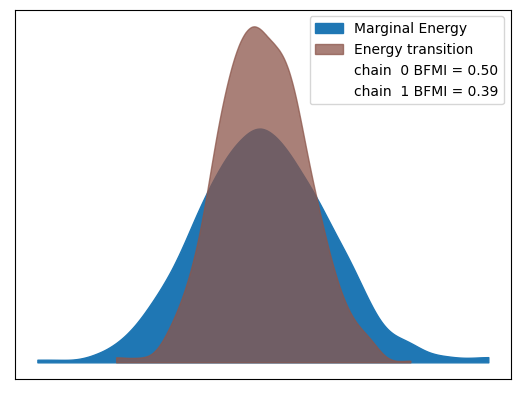

In [22]:
import arviz as az
az.plot_energy(single_hierarchy_trace)

#### To install graphviz on Windows:
```
conda install -c conda-forge python-graphviz
```

Note you may have to:
```
pip uninstall pyOpenSSL
pip uninstall pyOpenSSL
```

#### To install graphviz on the Mac:
```
brew install graphviz
```

Now copy this to the cell below:
```
pm.model_to_graphviz(single_hierarchy_model)
```

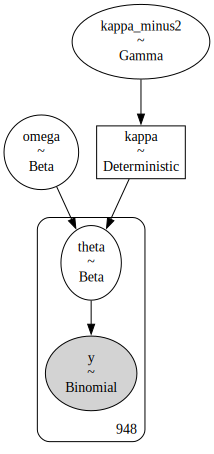

In [23]:
pm.model_to_graphviz(single_hierarchy_model)

Here's a way to compare all players with each other, assuming they all belong to the same *one* model:
```
az.plot_forest(single_hierarchy_trace, var_names=['theta'], combined=True)
```

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

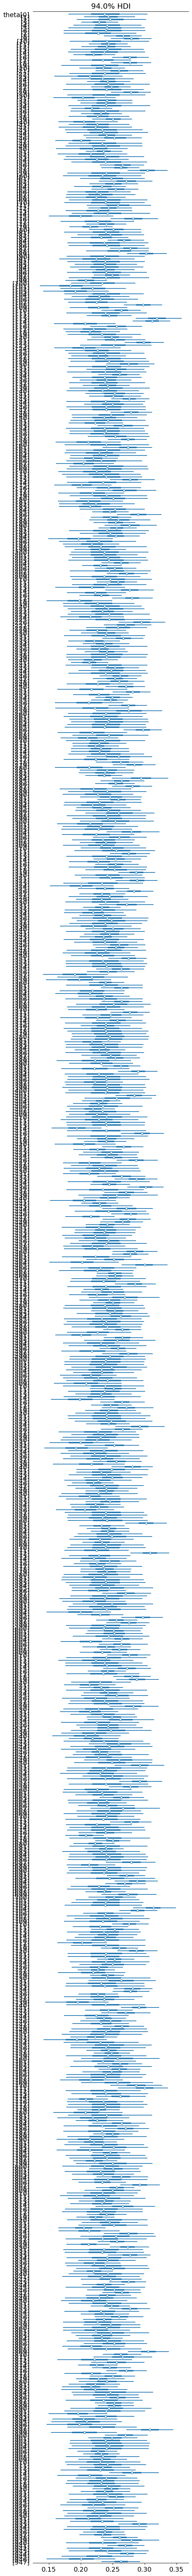

In [24]:
az.plot_forest(single_hierarchy_trace, var_names=['theta'], combined=True)

# Double Hierarchy Model
The model we're going to use now is even more complex, for two reasons:

- The model is double hierarchical because the data likelihood has a parameter that is modeled with a pdf, which pdf has parameters modeled by other pdfs, *which themselves have parameters modeled by other pdfs*!
- Now, we assume that positions are relevant, and that each position has distinct underlying statistics that every player inherits from. That means that the theta parameter is now a function of player position.

In other words, we build a **multi-model** representation where we assume that *baseball players playing different positions belong to different models*.

How do we do this? You assume that simulation parameters are based on positions!

```
num_positions = df['PriPosNumber'].nunique()
position_idx = df['PriPosNumber']
num_players = df['PlayerNumber'].nunique()
player_idx = df['PlayerNumber']

position_idx
```

In [25]:
num_positions = df['PriPosNumber'].nunique()
position_idx = df['PriPosNumber']
num_players = df['PlayerNumber'].nunique()
player_idx = df['PlayerNumber']

position_idx

0      1
1      7
2      4
3      4
4      3
      ..
943    1
944    5
945    1
946    1
947    9
Name: PriPosNumber, Length: 948, dtype: int64

There are 9 different positions in baseball:

In [26]:
num_positions

9

In [27]:
set(position_idx.values)

{1, 2, 3, 4, 5, 6, 7, 8, 9}

Let's give them an index:

In [28]:
position_idx2 = df['PriPosNumber'] - 1
position_idx2

0      0
1      6
2      3
3      3
4      2
      ..
943    0
944    4
945    0
946    0
947    8
Name: PriPosNumber, Length: 948, dtype: int64

In [29]:
set(position_idx2.values)

{0, 1, 2, 3, 4, 5, 6, 7, 8}

Let's set up our simulation:
```
with pm.Model() as double_hierarchy_model:
    # hyper-hyperpriors
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)

    # Parameters for positions (hyperpriors)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = num_positions)    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = num_positions)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
    
    # Parameters for players (priors)
    #theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=num_players)
    theta = pm.Beta('theta',
                     omega_c[position_idx2]*(kappa_c[position_idx2]-2)+1,
                    (1-omega_c[position_idx2])*(kappa_c[position_idx2]-2)+1,
                     shape = num_players)
    
    y = pm.Binomial('y', n=df['AtBats'], p=theta, observed=df['Hits'])
```

In [30]:
with pm.Model() as double_hierarchy_model:
    # hyper-hyperpriors
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)

    # Parameters for positions (hyperpriors)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = num_positions)    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = num_positions)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
    
    # Parameters for players (priors)
    #theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=num_players)
    theta = pm.Beta('theta',
                     omega_c[position_idx2]*(kappa_c[position_idx2]-2)+1,
                    (1-omega_c[position_idx2])*(kappa_c[position_idx2]-2)+1,
                     shape = num_players)
    
    y = pm.Binomial('y', n=df['AtBats'], p=theta, observed=df['Hits'])

Let's visualize:
```
pm.model_to_graphviz(double_hierarchy_model)
```

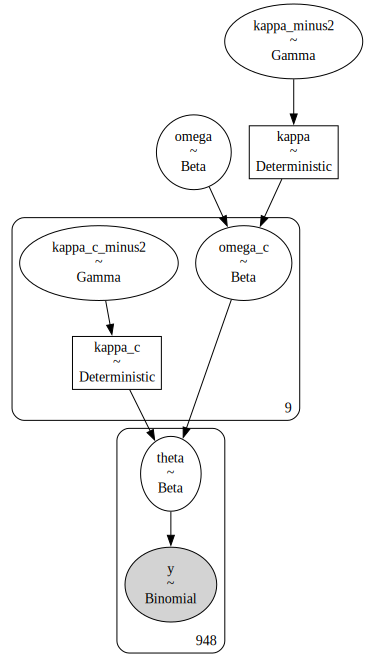

In [31]:
pm.model_to_graphviz(double_hierarchy_model)

Let's simulate:
```
with double_hierarchy_model:
    double_hierarchy_trace = pm.sample(cores=1)
```

In [32]:
with double_hierarchy_model:
    double_hierarchy_trace = pm.sample(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 68 seconds.


Let's plot the energy of the Hamiltonian to see if we converged:
```
az.plot_energy(double_hierarchy_trace)
```

<AxesSubplot: >

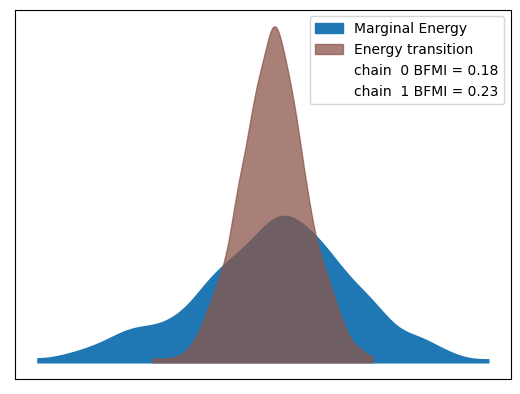

In [35]:
az.plot_energy(double_hierarchy_trace)

Hmmm..... Let's rerun with more iterations:
```
with double_hierarchy_model:
    double_hierarchy_trace2 = pm.sample(2000, cores=1)
```

In [36]:
with double_hierarchy_model:
    double_hierarchy_trace2 = pm.sample(2000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 86 seconds.


```
az.plot_energy(double_hierarchy_trace2)
```

<AxesSubplot: >

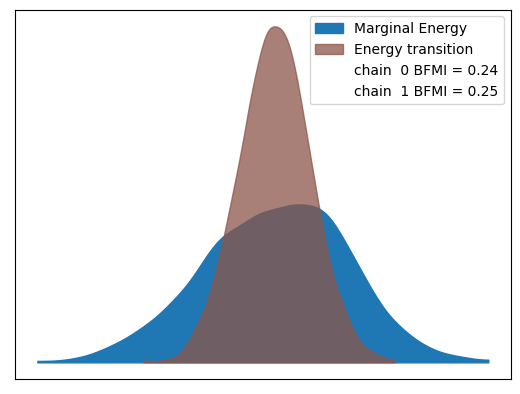

In [37]:
az.plot_energy(double_hierarchy_trace2)

Not much improvement :-(

Let's keep the simulation.

Now we can compare groups of players to each other!

Forest plot:
```
az.plot_forest(double_hierarchy_trace, var_names=['omega_c'], combined=True)
```

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

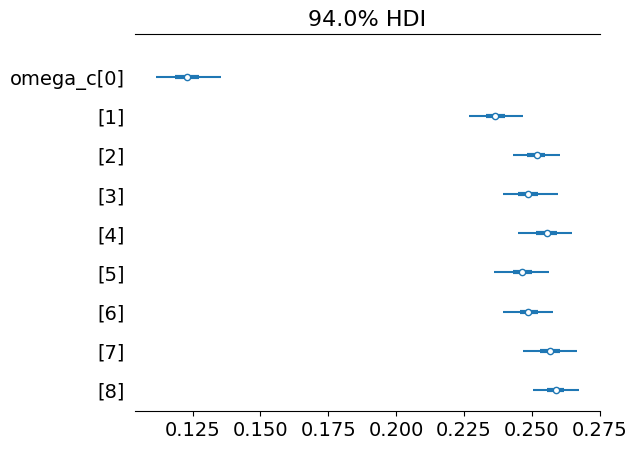

In [38]:
az.plot_forest(double_hierarchy_trace, var_names=['omega_c'], combined=True)

And now we can confirm that pitchers ***suck*** big-time compared to batters!

<br />
<center>
<img src="ipynb.images/minions-laughing.gif" width=500 />
</center>

Higher values of kappa imply that batting averages are more concentrated for the category, whereas lower values imply bigger deviations and the HDI also showcases uncertainties. 
```
az.plot_forest(double_hierarchy_trace, var_names=['kappa_c'], combined=True)
```

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

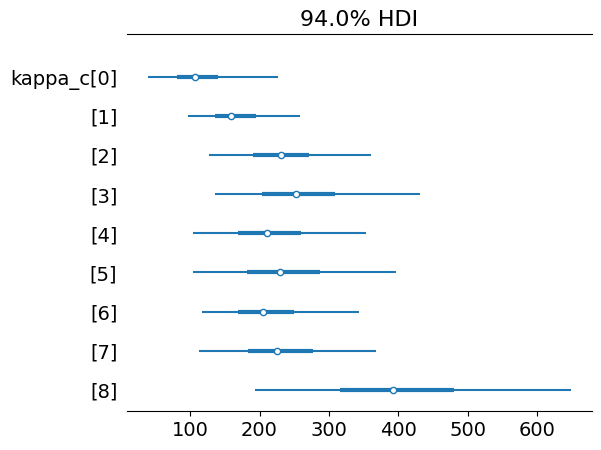

In [39]:
az.plot_forest(double_hierarchy_trace, var_names=['kappa_c'], combined=True)

# Homework (optional)
Can you think of another data model that you can introduce hierarchies in order to simulate less-derived categories?

# Reference

The [puppy dog book](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884)!

[Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan](https://jkkweb.sitehost.iu.edu/DoingBayesianDataAnalysis/)